In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester

In [9]:
# environment

load_dotenv(override=True)
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [11]:
openai = OpenAI()

In [13]:
with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [15]:
def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [17]:
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [19]:
DB = "products_vectorstore"

In [21]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [23]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [25]:
description(test[0])

"OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"

In [27]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [29]:
def vector(item):
    return model.encode([description(item)])

In [31]:
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [33]:
print(test[1].prompt)

How much does this cost to the nearest dollar?

Motorcraft YB3125 Fan Clutch
Motorcraft YB3125 Fan Clutch Package Dimensions 25.146 cms (L) x 20.066 cms (W) x 15.494 cms (H) Package Quantity 1 Product Type Auto Part Country Of Origin China Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch, Weight 5 pounds, Dimensions 10 x 7.63 x 6.25 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Rank Automotive Automotive Replacement Engine Fan Clutches 583, Domestic Shipping can be shipped within U.S., International Shipping This item can be shipped to select countries outside of the U.S. Learn More, Available October 10, 2007

Price is $225.00


In [35]:
documents, prices = find_similars(test[1])

In [37]:
print(make_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to estimate.

Potentially related product:
Motorcraft Fan Clutch Assembly - YB3130
Motorcraft Fan Clutch Assembly - YB3130 Package Dimensions 7.23 L x 4 H x 6.92 W (inches) Package Weight 5 pounds Country of Origin China Part Number YB3130 Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch Assembly, Weight 5 pounds, Dimensions 6.87 x 7.32 x 5.62 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Wattage 6.92 watts, Rank Automotive Automotive Replacement Engine Fan Clutches 698, Available October 10, 2007, Dimensions LxWxH 6.87 x 7.32 x 5.62 inches
Price is $223.78

Potentially related product:
Motorcraft- YB3126 Fan Clutch
Fan Clutch Package Dimensions 16.764 H x 24.384 L x 20.32 W (centimeters) Part number YB3126 Package Weight 7.4 pounds Fit type Vehicle Specific Brand Motorcraft, Electric fan design Blower, Power Source Electric, Style Modern, Dimensi

In [39]:
print(messages_for(test[1], documents, prices))

[{'role': 'system', 'content': 'You estimate prices of items. Reply only with the price, no explanation'}, {'role': 'user', 'content': 'To provide some context, here are some other items that might be similar to the item you need to estimate.\n\nPotentially related product:\nMotorcraft Fan Clutch Assembly - YB3130\nMotorcraft Fan Clutch Assembly - YB3130 Package Dimensions 7.23 L x 4 H x 6.92 W (inches) Package Weight 5 pounds Country of Origin China Part Number YB3130 Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch Assembly, Weight 5 pounds, Dimensions 6.87 x 7.32 x 5.62 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Wattage 6.92 watts, Rank Automotive Automotive Replacement Engine Fan Clutches 698, Available October 10, 2007, Dimensions LxWxH 6.87 x 7.32 x 5.62 inches\nPrice is $223.78\n\nPotentially related product:\nMotorcraft- YB3126 Fan Clutch\nFan Clutch Package Dimensions 16.764 H x 24.384 L x 20.32 W (centimeters) Part number YB31

In [41]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [43]:
get_price("The price for this is $99.99")

99.99

In [63]:
llama_local_client = OpenAI(
    base_url="http://localhost:11434/v1",  # Ollama local server
    api_key="ollama"  # Dummy key (required by client)
)

In [67]:
def llama3_local_rag(item):
    documents, prices = find_similars(item)
    retries = 3
    done = False
    while not done and retries > 0:
        try:
            response = llama_local_client.chat.completions.create(
                model="llama3.2",
                messages=messages_for(item, documents, prices),
                temperature=0.1,
                max_tokens=8,
                seed=42
            )
            reply = response.choices[0].message.content
            done = True
        except Exception as e:
            print(f"Error: {e}")
            retries -= 1
    return get_price(reply)

In [69]:
llama3_local_rag(test[1])


199.99

1: Guess: $391.41 Truth: $374.41 Error: $17.00 SLE: 0.00 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $199.99 Truth: $225.11 Error: $25.12 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $46.95 Truth: $61.68 Error: $14.73 SLE: 0.07 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $399.99 Truth: $599.99 Error: $200.00 SLE: 0.16 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $24.99 Truth: $16.99 Error: $8.00 SLE: 0.14 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $12.99 Truth: $31.99 Error: $19.00 SLE: 0.74 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $68.99 Truth: $101.79 Error: $32.80 SLE: 0.15 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $399.00 Truth: $289.00 Error: $110.00 SLE: 0.10 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $1,299.99 Truth: $635.86 Error: $664.13 SLE: 0.51 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $56.99 Truth: $65.99 Error: $9.00 SLE: 0.02 

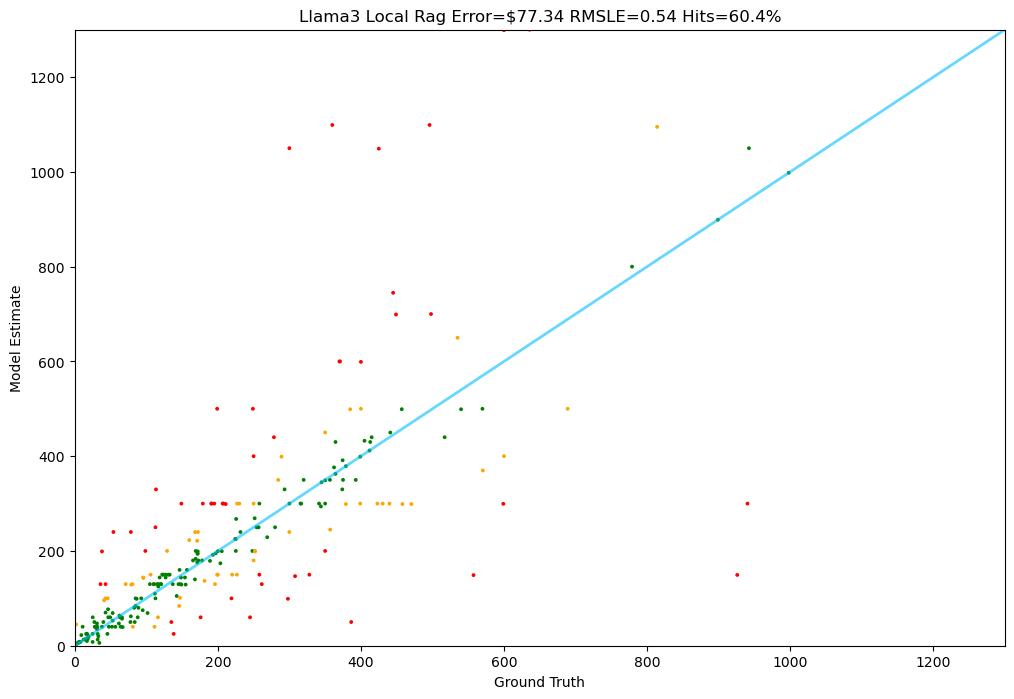

In [71]:
Tester.test(llama3_local_rag, test)

In [73]:
# Now lets check our agents

In [75]:
from agents.specialist_agent import SpecialistAgent

In [77]:
agent2 = SpecialistAgent()

In [79]:
agent2.price("Quadcast HyperX condenser mic for high quality podcasting")

150.0

In [81]:
from agents.frontier_agent import FrontierAgent

In [83]:
# Let's print the logs so we can see what's going on

import logging
root = logging.getLogger()
root.setLevel(logging.INFO)

In [85]:
agent = FrontierAgent(collection)

INFO:root:[Frontier Agent] Initializing Frontier Agent
INFO:root:[Frontier Agent] Frontier Agent is set up with Llama 3.2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda:0
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:root:[Frontier Agent] Frontier Agent is ready


In [87]:
agent.price("Quadcast HyperX condenser mic for high quality podcasting")

INFO:root:[Frontier Agent] Frontier Agent is performing a RAG search of the Chroma datastore to find 5 similar products


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:[Frontier Agent] Frontier Agent has found similar products
INFO:root:[Frontier Agent] Frontier Agent is about to call llama3.2 with context including 5 similar products
INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:[Frontier Agent] Frontier Agent completed - predicting $145.79


145.79

In [91]:
# Every thing is wroking fine